In [1]:
using SyntheticControls
using DataFrames
using StatsPlots
using CSVFiles
using StatFiles
using Statistics

### German Reunification Example

The following function loads data from the classical Synthetic Controls paper of [Abadie et al 2015](https://economics.mit.edu/files/11858) which is taken from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/24714).

- `pre` and `post` suffixes intervention correspond to before or after German reunification in 1990
- `Y0` and `Y1` are vectors of GDP for the candidate control countries and West Germany, respectively.
- `X0` and `X1` are a set of covariates for the candidate control countries and West Germany, respectively.

In [2]:
function load_repgermany()
    df = DataFrame(load("./data/repgermany.dta"))
    coltypes = [
        Int64,
        String,
        Int64,
        Float64,
        Union{Float64, Missing},
        Union{Float64, Missing},
        Union{Float64, Missing},
        Union{Float64, Missing},
        Union{Float64, Missing},
        Union{Float64, Missing},
        Union{Float64, Missing},
    ]

    for (col, t) in enumerate(coltypes)
        df[!,col] = convert.(t, df[:,col])
    end

    df_Y = select(df, (:year, :country, :gdp)...)
    df_Ymat = unstack(df_Y, :country, :gdp)

    filteryears(y::AbstractArray{Int64}, df) = filter(r -> r.year in y, df)
    filteryears(y::Int64, df) = filteryears([y], df)

    Y0_pre = select(filteryears(1960:1989, df_Ymat), Not([Symbol("West Germany"), :year]))
    Y1_pre = select(filteryears(1960:1989, df_Ymat), Symbol("West Germany"))
    Y0_post = select(filteryears(1989:2003, df_Ymat), Not([Symbol("West Germany"), :year]))
    Y1_post = select(filteryears(1989:2003, df_Ymat), Symbol("West Germany"))

    df_X = groupby(filteryears(1960:1990, df), :country)

    df_predictors = combine(df_X) do df_country
        dfy = y -> filteryears(y, df_country)

        return (
            gdp = mean(dfy(1971:1989).gdp),
            trade = mean(dfy(1971:1989).trade),
            infrate = mean(dfy(1971:1989).infrate),
            industry = mean(dfy(1971:1989).industry),
            schooling = mean(dfy(1970:5:1985).schooling),
            invest70 = mean(dfy(1980).invest70),
            invest80 = mean(dfy(1980).invest80),
        )
    end

    df_Xmat = permutedims(df_predictors, 1)
    X0 = select(df_Xmat, Not([Symbol("West Germany"), :country]))
    X1 = select(df_Xmat, Symbol("West Germany"))

    return (X0=X0, X1=X1, Y0_pre=Y0_pre, Y1_pre=Y1_pre, Y0_post=Y0_post, Y1_post=Y1_post)

end

load_repgermany (generic function with 1 method)

In [3]:
rep = load_repgermany()

(X0 = 7×16 DataFrame
 Row │ USA          UK          Austria      Belgium      Denmark      France  ⋯
     │ Float64      Float64     Float64      Float64      Float64      Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 12659.7      8923.11     10345.6      10094.4      10665.5      10049.5 ⋯
   2 │    17.5693     52.9661      68.9496     120.538       65.8278      41.3
   3 │     6.34725    10.2257       4.99979      6.12631      8.18341      8.2
   4 │    32.5208     40.7044      38.0041      37.1347      28.2573      35.0
   5 │    51.825      32.125       53.475       30.8         43.825       30.9 ⋯
   6 │     0.24568     0.22602      0.31104      0.28246      0.33284      0.3
   7 │    22.376      17.588       26.642       21.876       22.218       27.2
                                                              11 columns omitted, X1 = 7×1 DataFrame
 Row │ West Germany 
     │ Float64      
─────┼──────────────
   1 │  11112.1

Below, we treat each covariate data point and each year of the pre-intervention GDP time series equally.
We form vectors of 37 dimensional data in the matrix `WG0`, where each column corresponds to a candidate control country, and in a vector `WG1`, which corresponds to the same dimensions for West Germany.

Below this, the `SyntheticControls` module sets up a flat Dirichlet prior on the weights of 16 candidate control countries; that is, any synthetic control is equally likely (positive weights assigned to each of the 16 candidate countries sum to 1).
Then, the `LogLikelihood` function uses the data to define a log likelihood as the squared distance in data space.
This squared distance standardises the data, weighting by the variability of the data in each dimension.
Finally, `SMCProblem` combines the prior and log likelihood with a required ensemble size: that is, the total number of synthetic controls that we aim to construct.

In [4]:
WG0 = (vcat(Matrix{Float64}(rep.X0), Matrix{Float64}(rep.Y0_pre)))
WG1 = vec(vcat(Matrix{Float64}(rep.X1), Matrix{Float64}(rep.Y1_pre)))

WG_p = SyntheticControls.Prior(16)
WG_ℓ = SyntheticControls.LogLikelihood(permutedims(WG0), WG1)
WG_prob = SyntheticControls.SMCProblem(2^8, WG_p, WG_ℓ)

SyntheticControls.SMCProblem{SyntheticControls.Weightings{Matrix{Float64}}, Vector{Float64}, SyntheticControls._Dirichlet{Distributions.Dirichlet{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}, Float64}}, SyntheticControls.LogLikelihood{Matrix{Float64}, Vector{Float64}}, Vector{Float64}}(SyntheticControls.Weightings{Matrix{Float64}}([0.09685231805240341 0.1601816142480568 … 0.046101556920862 0.011806732183367051; 0.05578847370154999 0.008070150072799508 … 0.017101279100070844 0.010329687043835446; … ; 0.10208605653393121 0.010916918560274337 … 0.026320025999146034 0.06352299440664047; 0.022219701451517512 0.12041033330935996 … 0.01493543555513939 0.003591600993831003]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], SyntheticControls._Dirichlet{Distributions.Dirichlet{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}, Float64}}(Distributions.Dirichlet{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.O

The `sample!` function takes the `SMCProblem` and pushes it through an SMC process.
Each synthetic control weight vector initially sampled from the prior is the starting point of a random MCMC walk in the weight space.
I think the parameter `α` did... something like trying to balance out the distance of the synthetic control in data space from the intervention data, while also penalising the use of candidate controls that are far away from the intervention data.
That is, we could have West Germany be halfway between USA and Russia, but those are so different to West Germany that we prefer instead to choose e.g. Austria and UK, even if the resulting synthetic control is a slightly less good fit.
After `numMCMCIter` iterations of the MCMC walk are completed, the scale is reduced and the next generation started.
Thus the prior sample gets evolved towards a posterior sample.
The more generations that the SMC procedure is run for, the less spread around the optimum single synthetic control point estimate is allowed.

In [5]:
fun = SyntheticControls.sample!(
	WG_prob,
	numMCMCIter=1000,
	numGenerations=10,
	scale=5.0,
	α=0.1,
)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/tprescott/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:00
  generation:  10
  ESS:         256.0

#28 (generic function with 1 method)

The weights used in this ensemble can be visualised, as shown below.
On the left is the mean weight over the entire ensemble.
On the right is each of the individual synthetic control weight vectors (summing to 1.0).

In [6]:
plot(WG_prob.ws)

Below this, the 30 years pre-intervention and 15 years post-intervention GDP time series are shown.
We compare the ensemble of synthetic West Germanies, in grey,
against the true trajectory of West Germany in cyan.
We can then judge whether there is a significant difference between the true trajectory and all synthetic controls.
A single synthetic control cannot necessarily allow for such a confident conclusion, due to a lack of uncertainty quantification.

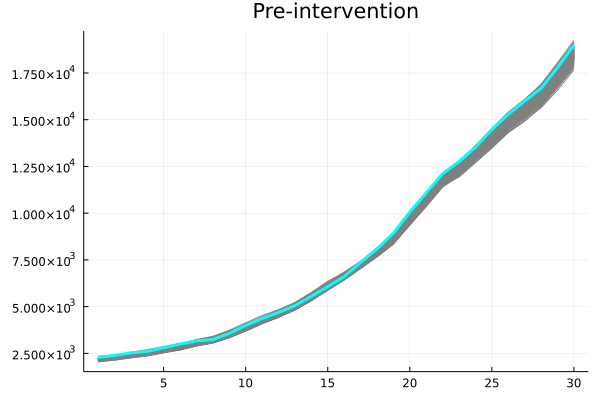

In [7]:
fig_pre = plot(Matrix{Float64}(rep.Y0_pre)*WG_prob.ws.w, c=:grey, legend=:none)
plot!(fig_pre, Matrix{Float64}(rep.Y1_pre), c=:cyan, linewidth=3, title="Pre-intervention")

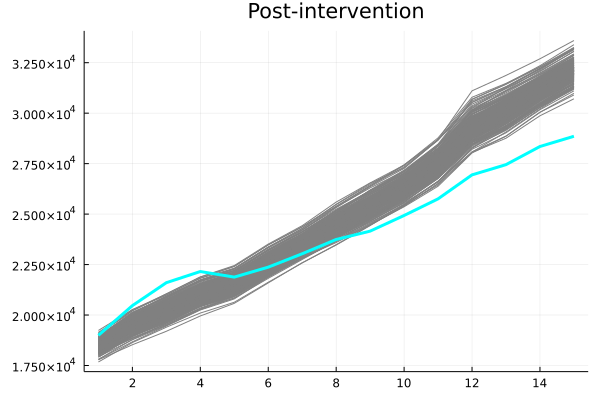

In [8]:
fig_post = plot(Matrix{Float64}(rep.Y0_post)*WG_prob.ws.w, c=:grey, legend=:none)
plot!(fig_post, Matrix{Float64}(rep.Y1_post), c=:cyan, linewidth=3, title="Post-intervention")

## Health Index
The following is a proof of principle for applying the approach described above
to the ONS National Health Index Beta.
The standardising / equal weighting approach of the West Germany example
should be altered here, because the indicator values are already standardised.
In the health index, the indicators are in fact weighted.
So this weighting should also apply in the synthetic control construction.
NB this is still to be implemented.

In [9]:
df = DataFrame(load("./data/HI.csv"))
subset!(df, :Year => y -> y .== 2015)

,Area code,Area name,Year,GP_dist,activity,air_poll,alc
,String,String,Int64,Float64,Float64,Float64,Float64
1,E06000001,Hartlepool,2015,106.616,94.7599,105.593,105.022
2,E06000002,Middlesbrough,2015,108.066,94.764,105.535,104.994
3,E06000003,Redcar and Cleveland,2015,104.663,94.8452,105.606,105.084
4,E06000004,Stockton-on-Tees,2015,104.365,94.6818,105.581,105.017
5,E06000005,Darlington,2015,105.542,94.834,105.605,105.059
6,E06000006,Halton,2015,106.906,94.66,105.37,105.021
7,E06000007,Warrington,2015,106.242,94.7985,105.378,105.074
8,E06000008,Blackburn with Darwen,2015,109.276,94.751,105.475,105.028
9,E06000009,Blackpool,2015,109.02,94.6902,104.862,104.929


In [10]:
function hi_synthetic_controls(intervention_UTLA::String)
    
    df_0 = subset(df, "Area name" => n -> n .!= intervention_UTLA)
    df_1 = subset(df, "Area name" => n -> n .== intervention_UTLA)
    X_0 = Matrix{Float64}(df_0[:, 4:end])
    X_1 = vec(Matrix{Float64}(df_1[:, 4:end]))
    
    numControls, numIndicators = size(X_0)
    p_HI = SyntheticControls.Prior(numControls)
    ℓ_HI = SyntheticControls.LogLikelihood(X_0, X_1)

    prob_HI = SyntheticControls.SMCProblem(2^8, p_HI, ℓ_HI)
    test_HI = SyntheticControls.sample!(prob_HI, numMCMCIter=1000, numGenerations=12, scale=5, α = 0.1)
    
    df_sc = hcat(df_0[:, ["Area code", "Area name"]], DataFrame(prob_HI.ws.w, :auto))
    return prob_HI, df_sc
end

hi_synthetic_controls (generic function with 1 method)

In [13]:
p_sc, sc = hi_synthetic_controls("Barnet");

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/tprescott/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00
  generation:  12
  ESS:         256.0

In [14]:
sort!(sc, :x200, rev=true)

,Area code,Area name,x1,x2,x3
,String,String,Float64,Float64,Float64
1,E09000020,Kensington and Chelsea,0.0924867,0.0683687,0.0993572
2,E09000009,Ealing,0.074811,0.103015,0.0820756
3,E09000015,Harrow,0.106802,0.0928378,0.071623
4,E09000021,Kingston upon Thames,0.0305397,0.0879941,0.0482634
5,E09000024,Merton,0.036499,0.0103981,0.0228561
6,E09000006,Bromley,0.0152192,0.0381376,0.026437
7,E06000022,Bath and North East Somerset,0.0238539,0.026199,0.0210962
8,E09000032,Wandsworth,0.0350329,0.0625856,0.0524823
9,E09000005,Brent,0.00115178,0.00828472,0.00347107


There is no time series to show anything nice.
We could show the weights but there are so many data points the visualisation screams.